In [1]:
%run support.py
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py, time, json
from datetime import datetime, timedelta
from scipy.optimize import curve_fit, brentq
from lmfit import minimize, Parameters, report_fit
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')

#MySQL stuff
import mysql.connector
mysqlconfig = {
    "host": "phys-dots-data.physik.unibas.ch",
    "user": "logger",
    "passwd": "CryoH4ll",
    "database": "logs"
}
# END MySQL

Rk = 25813
R_wire=4200
timeformat = mdates.DateFormatter('%H:%M')
datediff = mdates.datestr2num('1970-01-01')-mdates.datestr2num('1904-01-01')
deltaUTC = datetime.now() - datetime.utcnow()
#datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown38"
datafolder = "./data/Measurements/Cooldown20190924"

print(f"Datediff between fucking Apple and UNIX TIME STAMP {datediff} days or {datediff*24*3600} seconds")
print(f"Delta UTC = {deltaUTC}")

Datediff between fucking Apple and UNIX TIME STAMP 24107.0 days or 2082844800.0 seconds
Delta UTC = 1:59:59.999998


# Load Data
Note that the function GetBFData() will not work unless you are on UNIBASEL's network. This grabs the temperature data from the BlueFors fridge that I store on an internal server.
The data relevant to this paper is included in the data folder.

In [2]:
gT = 0.302*2/Rk
Ec = 1.51986/2
def LoadData(wavenums, GetTimeFromLogs=False):
    ts = np.array([])
    gs = np.array([])
    bs = np.array([])
    for i in range(len(wavenums)):
        filename = f"d{wavenums[i]}_time.h5"
        with h5py.File(f"{datafolder}/{filename}", 'r') as f:
            t = np.array(f['x_array'])
            g = np.array(f['GcbtlowEc'])*2/Rk
            b = np.array(f['bzIPSB'])
            logs = json.loads(f['metadata'].attrs['sweep_logs'])
        #print("wavenumber =",wavenums[i], "t[0] =", t[0]-datediff*24*3600, datetime.utcfromtimestamp(t[0]-datediff*24*3600))
        if GetTimeFromLogs:
            time_started = datetime.strptime(logs['time_started'], '%d/%m/%Y %H:%M:%S')
            time_completed = datetime.strptime(logs['time_completed'], '%d/%m/%Y %H:%M:%S')
            last_index = np.where(np.logical_not(np.isnan(g)))[0][-1]
            t = np.linspace(time_started.timestamp(), time_completed.timestamp(), last_index+1)

        t = t[0:t.shape[0]]
        g = g[0:t.shape[0]]
        b = b[0:t.shape[0]]
        g = MakeSmoothie(g, ws=70)
        if i>0 and t[0]-ts[-1] > 20:
            #print(f"Time shift={(t[0]-ts[-1])}")
            t = t-(t[0]-ts[-1])
            
        g = 1/(1/g-2*R_wire)
        
        ts = np.append(ts, t)
        gs = np.append(gs, g)
        bs = np.append(bs, b)
    return ts, gs, bs

#def GetBFData(sensor_id, start_time, end_time):
#    sql = f"SELECT UNIX_TIMESTAMP(`time`), `value` FROM `records` WHERE `time`>'{start_time}' AND `time`<'{end_time}' AND `sensor_id`={sensor_id} ORDER BY `time` ASC"
#    print(sql)
#    db = mysql.connector.connect(**mysqlconfig)
#    cursor = db.cursor()
#    cursor.execute(sql)
#    return np.array(cursor.fetchall())

max_time = 7 # hours
PTon_time, PTon_g, PTon_b = LoadData([304], GetTimeFromLogs=True)
time_started = PTon_time[0]
time_completed = time_started + max_time*3600
PTon_time -= PTon_time[0]
PTon_Te = Tcbt_Cu(PTon_g/gT, Ec=Ec)
b8_reftime = np.interp([8], PTon_b[PTon_b>1][::-1], PTon_time[PTon_b>1][::-1])[0]
print(f"b8_reftime = {b8_reftime:.0f} seconds")

# PT ON
# Get BF Data
#result_PTon1 = GetBFData(1, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PTon1.npy", result_PTon1)
result_PTon1 = np.load(f"{datafolder}/result_PTon1.npy")
t_PTon1=result_PTon1[:,0]/3600
t_PTon1 -= t_PTon1[0]

#result_PTon3 = GetBFData(3, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PTon3.npy", result_PTon3)
result_PTon3 = np.load(f"{datafolder}/result_PTon3.npy")
t_PTon3=result_PTon3[:,0]/3600
t_PTon3 -= t_PTon3[0]

#result_PTon6 = GetBFData(6, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PTon6.npy", result_PTon6)
result_PTon6 = np.load(f"{datafolder}/result_PTon6.npy")
t_PTon6=result_PTon6[:,0]/3600
t_PTon6 -= t_PTon6[0]

# PT OFF
PToff_time, PToff_g, PToff_b = LoadData([219], GetTimeFromLogs=True)
PToff_time -= PToff_time[0]
PToff_Te = Tcbt_Cu(PToff_g/gT, Ec=Ec)
b8_time_off = np.interp([8], PToff_b[PToff_b>1][::-1], PToff_time[PToff_b>1][::-1])[0]
PToff_time -= (b8_time_off-b8_reftime)

#PT OFF DC Correct
PToffdc_time, PToffdc_g, PToffdc_b = LoadData([471, 473], GetTimeFromLogs=True)
PToffdc_time -= PToffdc_time[0]
PToffdc_Te = Tcbt_Cu(PToffdc_g/gT, Ec=Ec)
b8_time_offdc = np.interp([8], PToffdc_b[PToffdc_b>1][::-1], PToffdc_time[PToffdc_b>1][::-1])[0]
PToffdc_time -= (b8_time_offdc-b8_reftime)
t1_off = (PToffdc_time[np.min(np.where(PToffdc_b<2.001))] -1*60)/3600

#####################################################################
# Fridge Statistics
#filename = f"d471_time.h5"
filename = f"d819_time.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    t = np.array(f['x_array'])
    b = np.array(f['bzIPSB'])
    logs = json.loads(f['metadata'].attrs['sweep_logs'])
t_PToff = t[np.logical_not(np.isnan(t))]-t[0]
b_PToff = b[np.logical_not(np.isnan(t))]
b8_time_BFdata = np.interp([8], b[b>1][::-1], t_PToff[b_PToff>1][::-1])[0]
time_started = datetime.timestamp(datetime.strptime(logs['time_started'] , '%d/%m/%Y %H:%M:%S')) + 2*3600
time_completed = time_started + max_time*3600 + 300

print(f"LOG {logs['time_started']}")
#result_PToff1 = GetBFData(1, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PToff1.npy", result_PToff1)
result_PToff1 = np.load(f"{datafolder}/result_PToff1.npy")
t_PToff1 = result_PToff1[:,0]/3600
t_PToff1 -= (b8_time_off-b8_reftime)/3600 + t_PToff1[0]

#result_PToff3 = GetBFData(3, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PToff3.npy", result_PToff3)
result_PToff3 = np.load(f"{datafolder}/result_PToff3.npy")
t_PToff3=result_PToff3[:,0]/3600
t_PToff3 -= (b8_time_off-b8_reftime)/3600 + t_PToff3[0]

#result_PToff6 = GetBFData(6, datetime.strftime(datetime.fromtimestamp(time_started), '%Y-%m-%d %H:%M:%S'), datetime.strftime(datetime.fromtimestamp(time_completed), '%Y-%m-%d %H:%M:%S'))
#np.save(f"{datafolder}/result_PToff6.npy", result_PToff6)
result_PToff6 = np.load(f"{datafolder}/result_PToff6.npy")
t_PToff6=result_PToff6[:,0]/3600
t_PToff6 -= (b8_time_off-b8_reftime)/3600 + t_PToff6[0]

magT = result_PToff3[:,1]
t2_off = t_PToff3[np.argmax(magT)]
duration_off = t2_off - t1_off

b8_reftime = 3726 seconds
LOG 05/01/2020 16:55:44


/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/var/opt/jupyterhub/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


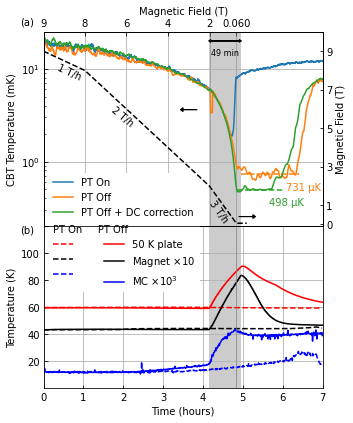

In [3]:
fig = plt.figure(figsize=(5,5.5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[12, 10], wspace=0, hspace=0.0, top=0.95, bottom=0.05)
ax = []
[ax.append(plt.subplot(gs[i])) for i in range(2)]
[ax[i].set_facecolor('none') for i in range(2)]
fig.subplots_adjust(wspace=0, hspace=0)
ax0top = ax[0].twiny()
ax0right = ax[0].twinx()

#####################################################################
# PT On
ax[0].plot(PTon_time/3600, PTon_Te, color=colors[0], label=f"PT On")
ax[1].plot(t_PTon1, result_PTon1[:,1], '--', color='r', label=" ")
ax[1].plot(t_PTon3, result_PTon3[:,1]*10, '--', color='k', label=" ")
ax[1].plot(t_PTon6, result_PTon6[:,1]*1e3, '--', color='b', label=" ")

#####################################################################
# PT Off
ax[0].plot(PToff_time/3600, PToff_Te, color=colors[1], label=f"PT Off")
slc = np.where(np.logical_and(PToff_time/3600 >4.95, PToff_time/3600 <6.1))
avg_lowPToffT = np.average(PToff_Te[slc])
ax[0].plot([PToff_time[slc][0]/3600, PToff_time[slc][-1]/3600 + 0.3], [avg_lowPToffT, avg_lowPToffT], '--', color=colors[1])
ax[0].text((PToff_time[slc][-1]-60)/3600, avg_lowPToffT-2.4e-1, f'{avg_lowPToffT*1e3:.0f} µK', color=colors[1])

#####################################################################
# PT Off DC correct
ax[0].plot(PToffdc_time/3600, PToffdc_Te, color=colors[2], label=f"PT Off + DC correction")
slc = np.where(np.logical_and(PToffdc_time/3600 >4.85, PToffdc_time/3600 <5.7))
avg_lowPToffdcT = np.average(PToffdc_Te[slc])
ax[0].plot([PToffdc_time[slc][0]/3600, PToffdc_time[slc][-1]/3600+0.3], [avg_lowPToffdcT, avg_lowPToffdcT], '--', color=colors[2])
ax[0].text(PToffdc_time[slc][-1]/3600-0.05, avg_lowPToffdcT-1.6e-1, f'{avg_lowPToffdcT*1e3:.0f} µK', color=colors[2])
minind = np.where(PToffdc_Te == np.min(PToffdc_Te))

# Top Magnetic Field Axis
blabels = np.array([9, 8, 6, 4, 2, 0.06001])
btimes = np.interp(blabels, PToffdc_b[PToffdc_b>0.06][::-1], PToffdc_time[PToffdc_b>0.06][::-1])/3600
ax0top.set_xlim(0, max_time)
#btickvalue = np.array([np.min(np.where(np.abs(blabels[i]-PToffdc_b) < 2e-3)) for i in range(4)])/len(PToffdc_b)
ax0top.set_xticks(btimes)
ax0top.set_xticklabels(["9", "8", "6", "4", "2", "0.060"])

ax0right.plot((t_PToff-t_PToff[0])/3600, b_PToff, '--k')
ax0right.text(0.3, 7.5, "1 T/h", rotation=-25)
ax0right.text(1.65, 5.1, "2 T/h", rotation=-40)
ax0right.text(4.1, 0.1, "3 T/h", rotation=-55)

ax[1].plot(t_PToff1, result_PToff1[:,1], label='50 K plate', color='r')
ax[1].plot(t_PToff3, result_PToff3[:,1]*10, label=r'Magnet $\times 10$', color='k')
ax[1].plot(t_PToff6, result_PToff6[:,1]*1e3, label=r'MC $\times 10^3$', color='b')

ax[0].fill_between([t1_off, t2_off], [60, 60], [0.1 ,0.1], alpha=0.4, color='grey', lw=0)
ax[0].arrow(t1_off, 20, duration_off-.05, 0, head_width=1.5, head_length=.05)
ax[0].arrow(t1_off + duration_off, 20, -duration_off+.05, 0, head_width=1.5, head_length=.05)
ax[0].text(t1_off+0.05, 14, f'{(duration_off)*60:.0f} min', fontsize=8)

ax[0].tick_params(axis="y", which='both', direction='in')
ax0right.tick_params(axis="y", which='both', direction='in')
ax0top.tick_params(axis="x", which='both', direction='in')

ax[0].set_ylim(0.2,25)
ax[0].set_yscale('log')
#ax[0].set_yticks([1,10])
#ax[0].set_yticklabels([1,10])
#ax[0].set_major_formatter(mpl.ticker.ScalarFormatter())
ax[0].set_xticks([])
ax[0].grid()
ax[0].legend(loc=3, framealpha=1, edgecolor='w')
ax[0].set_ylabel('CBT Temperature (mK)')
ax0right.set_ylabel('Magnetic Field (T)')
ax0top.set_xlabel('Magnetic Field (T)')
ax0top.grid()
ax0top.set_zorder(-1)
ax0right.set_yticks([0,1,3,5,7,9])
ax0right.set_ylim(-0.1,10)

ax[0].arrow(0.55, 0.6, -0.05, 0, head_width=0.02, head_length=.01, color='k', transform=ax[0].transAxes)
ax[0].arrow(0.7, 0.05, 0.05, 0, head_width=0.02, head_length=.01, color='k', transform=ax[0].transAxes)

ax[1].set_ylim(0, 120)
ax[1].fill_between([t1_off, t2_off], [120, 120], [0 ,0], alpha=0.4, color='grey', lw=0) 
ax[1].set_yticks([20,40,60,80,100])
ax[1].set_xlabel('Time (hours)')
ax[1].set_ylabel('Temperature (K)')
ax[1].plot([btimes[-1], btimes[-1]], [0,200], color='grey', alpha=0.7, lw=1)
ax[1].grid()
ax[1].legend(loc=(0.02, 0.6), framealpha=1, edgecolor='w', ncol=2, title="PT On     PT Off")._legend_box.align = "left"

ax[0].set_xlim(0, max_time)
ax[1].set_xlim(0, max_time)

ax[0].text(-0.6, 30, '(a)')
ax[1].text(-0.6, 115, '(b)')

fig.savefig('FS3.pdf', bbox_inches='tight', pad_inches=0)